In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline

### Problem 1

In [2]:
# read in data
df=pd.read_csv("data/strongdrink.txt")
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df["cultivar"].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

#### a. Multinomial logistic regression

In [4]:
# Training and testing sets
y=df["cultivar"]
X=df[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)

In [5]:
clf = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
pd.DataFrame({"j=1":np.append(clf.intercept_[0],clf.coef_[0]),
              "j=2":np.append(clf.intercept_[1],clf.coef_[1])},
               index=["beta0","beta1",'beta2','beta3','beta4'])

,j=1,j=2
beta0,-24.010989,22.802446
beta1,1.700403,-1.468044
beta2,-0.265605,-0.333053
beta3,1.223894,0.664012
beta4,0.022756,-0.922712


In [6]:
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



The error rates are 13%, 0%, and 0% for group 1,2, and 3, respectively.

The model is best at predicting the third group (highest f1-score).

The one with the most observations is the second group. So the most accurately predicted category is not the one with the most observations.

#### b. LOOCV

In [7]:
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)
X=df[["alco","malic","tot_phen","color_int"]].values
y=df["cultivar"].values

ytest = np.zeros(X.shape[0])
ypred = np.zeros(X.shape[0])

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ytest[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1


MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('LOOCV test estimate MSE mean=', MSE_loo)
print('LOOCVtest estimate MSE standard err=', MSE_loo_std)

LOOCV test estimate MSE mean= 0.07954545454545454
LOOCVtest estimate MSE standard err= 0.2705882022679695


In [8]:
# Or we can use model_selection.cross_val_score
resloo=cross_val_score(clf, X, y, cv=loo)
print("LOOCV MSE: %.4f (%.2f%%)" % (1-resloo.mean(), resloo.std()*100.0))

LOOCV MSE: 0.0795 (27.06%)


In [9]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



The error rates are 10%, 9%, and 4% for group 1,2, and 3, respectively. Rates increase compared with results from part (a).

#### c. k-fold cross validation

In [11]:
k=4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)

ytest = np.zeros(X.shape[0])
ypred = np.zeros(X.shape[0])
k_ind = int(0)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ytest[test_index] = y_test

    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred

    n = len(y_pred)
    err=[1 if y_test[i] != y_pred[i] else 0 for i in range(n)]  
    MSE_vec_kf[k_ind]=np.mean(err)
    
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.09090909090909091 test estimate MSE standard err= 0.04821182598999188


In [12]:
# Or we can use model_selection.cross_val_score
reskf=cross_val_score(clf, X, y, cv=kf)
print("3-fold MSE: %.4f (%.2f%%)" % (1-reskf.mean(), reskf.std()*100.0))

3-fold MSE: 0.0909 (4.82%)


In [13]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.91      0.91      0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



The error rates are 13%, 9%, and 4% for group 1,2, and 3, respectively. Rate for group 1 becomes worse and rates for group 2 and 3 remain the same, compared with the results from part (b).

### Problem 2

In [14]:
df=pd.read_csv("data/CoolIndex.txt",names=["Age","Cool"])
df.head()

,Age,Cool
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


#### a. scatterplot

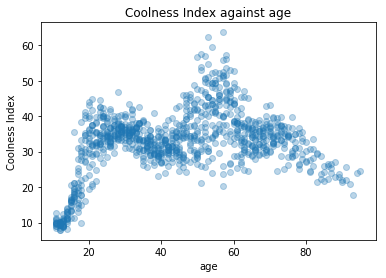

In [15]:
plt.scatter(df.Age,df.Cool,alpha=0.3)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

#### b. stepwise function with OLS

In [16]:
df["G1"]=np.where((df.Age>=11) & (df.Age<22),1,0)
df["G2"]=np.where((df.Age>=22) & (df.Age<40),1,0)
df["G3"]=np.where((df.Age>=40) & (df.Age<59),1,0)
df["G4"]=np.where((df.Age>=59) & (df.Age<77),1,0)
df["G5"]=np.where((df.Age>=77) & (df.Age<=95),1,0)

In [17]:
X=df[["G1","G2","G3","G4","G5"]]
res=sm.OLS(df.Cool,X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        10:39:02   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

The estimated step function values for each bin are 20.10, 34.48, 37.64, 35.23, 27.30.

In [18]:
res.predict([0,0,0,1,0])

array([35.22540004])

The predicted coolness of a 73-year old from the stepwise function is 35.

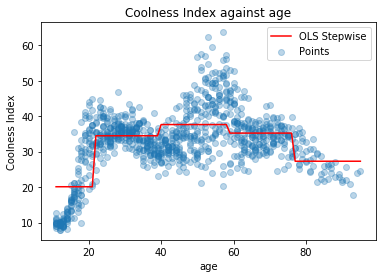

In [19]:
plt.scatter(df.Age,df.Cool,alpha=0.3,label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

#### c. linear spline 

In [20]:
#Group data by age as LSQUnivariateSpline requires x to be strictly increasing
df2=df.groupby('Age').mean()
df2['Age']=df2.index
df2[['Age','Cool']].head()

,Age,Cool
Age,,
11.0,11.0,10.110237
12.0,12.0,9.365623
13.0,13.0,10.015882
14.0,14.0,11.747109
15.0,15.0,15.434739


In [21]:
knots=[22,40,59,77]
ls=LSQUnivariateSpline(np.array(df2.Age), np.array(df2.Cool), t=knots, k=1)

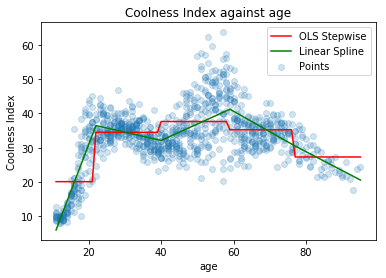

In [22]:
plt.scatter(df.Age,df.Cool,alpha=0.2,label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2.Age,ls(df2.Age),"g",label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [23]:
ls(73)

array(32.86784862)

The predicted coolness of a 73-year old from the cubic spline is 32.86.

#### d. cubic spline

In [24]:
cs=LSQUnivariateSpline(np.array(df2.Age), np.array(df2.Cool), t=knots, k=3)

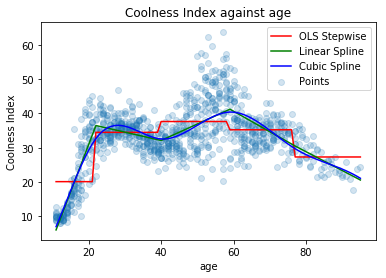

In [25]:
plt.scatter(df.Age,df.Cool,alpha=0.2,label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2.Age,ls(df2.Age),"g",label = "Linear Spline")
plt.plot(df2.Age,cs(df2.Age),"b",label = "Cubic Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [27]:
cs(73)

array(32.64230107)

The predicted coolness of a 73-year old from the cubic spline is 32.64.

***An interactive plot generated by Plotly package:

https://plot.ly/~lliu95877/4/coolness-index-against-age/#/